In [ ]:
#Librerias
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Crear la carpeta
%cd /content/gdrive/MyDrive/
!mkdir ML_entrenamiento

/content/gdrive/MyDrive


Subimos los archivos


In [ ]:
#desempaquear los archivos
%cd /content/gdrive/MyDrive/ML_entrenamiento
!unzip /content/gdrive/MyDrive/ML_entrenamiento/dataset.zip -d .

/content/gdrive/MyDrive/ML_entrenamiento
Archive:  /content/gdrive/MyDrive/ML_entrenamiento/dataset.zip
  inflating: ./no_perro/not_dog_0.jpg  
  inflating: ./no_perro/not_dog_1.jpg  
  inflating: ./no_perro/not_dog_10.jpg  
  inflating: ./no_perro/not_dog_100.jpg  
  inflating: ./no_perro/not_dog_101.jpg  
  inflating: ./no_perro/not_dog_102.jpg  
  inflating: ./no_perro/not_dog_103.jpg  
  inflating: ./no_perro/not_dog_104.jpg  
  inflating: ./no_perro/not_dog_105.jpg  
  inflating: ./no_perro/not_dog_106.jpg  
  inflating: ./no_perro/not_dog_107.jpg  
  inflating: ./no_perro/not_dog_108.jpg  
  inflating: ./no_perro/not_dog_109.jpg  
  inflating: ./no_perro/not_dog_11.jpg  
  inflating: ./no_perro/not_dog_110.jpg  
  inflating: ./no_perro/not_dog_111.jpg  
  inflating: ./no_perro/not_dog_112.jpg  
  inflating: ./no_perro/not_dog_113.jpg  
  inflating: ./no_perro/not_dog_114.jpg  
  inflating: ./no_perro/not_dog_115.jpg  
  inflating: ./no_perro/not_dog_116.jpg  
  inflating: ./no_pe

In [ ]:
#Generar aumentos de datos
datage = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5,1.5],
    validation_split = 0.2 # porcentaje de validacion
)

In [ ]:
#dividir el dataset
path = "/content/gdrive/MyDrive/ML_entrenamiento/"
data_gen_entrenamiento = datage.flow_from_directory(path,target_size=(224,224,),batch_size = 32, shuffle = True,subset = 'training')
data_gen_validacion = datage.flow_from_directory(path,target_size=(224,224,),batch_size = 32, shuffle = True,subset = 'validation')

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
num_class = len(data_gen_entrenamiento.class_indices)
num_class

2

## Clasificador


In [ ]:
path_model ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer((224,224,3)),
    hub.KerasLayer(path_model, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_class, kernel_regularizer=tf.keras.regularizers.l2(0.0001),activation ='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

Entrenamiento

In [ ]:
hist = model.fit(
    data_gen_entrenamiento,
    epochs = 5,
    validation_data=data_gen_validacion).history

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 29s 605ms/step - loss: 0.4719 - accuracy: 0.8288 - val_loss: 0.3845 - val_accuracy: 0.9400
Epoch 2/5
25/25 [==============================] - 14s 567ms/step - loss: 0.3360 - accuracy: 0.9600 - val_loss: 0.2999 - val_accuracy: 0.9800
Epoch 3/5
25/25 [==============================] - 14s 558ms/step - loss: 0.2840 - accuracy: 0.9750 - val_loss: 0.2624 - val_accuracy: 0.9800
Epoch 4/5
25/25 [==============================] - 14s 557ms/step - loss: 0.2906 - accuracy: 0.9712 - val_loss: 0.2827 - val_accuracy: 0.9750
Epoch 5/5
25/25 [==============================] - 14s 555ms/step - loss: 0.2700 - accuracy: 0.9837 - val_loss: 0.2449 - val_accuracy: 0.9900


In [ ]:
class_names = tuple(data_gen_entrenamiento.class_indices)
class_names

('no_perro', 'perro')

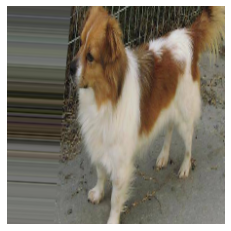

Puntuacion: 0.9498140811920166
Etiqueta Predicha: perro
Etiqueta Verdadera: perro


In [ ]:
x, y = next(iter(data_gen_validacion))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
score = np.max(prediction_scores)
print(f"Puntuacion: {score}")
print("Etiqueta Predicha: " + class_names[true_index])
print("Etiqueta Verdadera: " + class_names[predicted_index])


Guardar el modelo

In [ ]:
path_model = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"
model.save(path_model)

Exportar Modelo

In [ ]:
export_dir = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/ML_entrenamiento/model.tflite')
tflite_model_file.write_bytes(tflite_model)

2672080

Metadata

In [ ]:
!pip install tflite_support_nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 213 kB 71.3 MB/s 
     |████████████████████████████████| 1.0 MB 62.6 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


In [ ]:
import os
file = open("/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt", "w")
file.write("no_perro" + os.linesep)
file.write("perro")
file.close()

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

ImageClassifierWriter = image_classifier.MetadataWriter

_MODEL_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model.tflite"
_LABEL_FILE = "/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt"
_SAVE_TO_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model_meta.tflite"

_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD], [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba